# Creating confusion matrices for report

Copied from 20210505_multiclass_XGB_optimized.ipynb.


In [25]:
# Load up the requisite libraries and submodules.
import copy
import joblib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import time
import xgboost as xgb

from datetime import datetime
from dynomics import models
from matplotlib.colors import LogNorm
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler


# Define file locations.
DATA_DIR = "../data/multiclass/"

In [2]:
# Load up the station IDs. Some of the Accl
station_filenames_list = [
    filename for filename in os.listdir(path=DATA_DIR)
    if (filename[-7:]==".pickle") and ("53155" not in filename)
]

# List of 
stations_id_list = list(
    set(
        fname.split("_")[2].split(".")[0] for fname in station_filenames_list
    )
)

In [3]:
# import pickle5 as pickle

# with open(DATA_DIR+"mc_features_03054.pickle", "rb") as fh:
#     data = pickle.load(fh)

# data.to_pickle("test.pickle", protocol=2)

# df = pd.read_pickle("test.pickle")

# df.values

In [3]:
# Load features and targets into features and targets dictionaries, indexed
# by station ID number.
template_dict = {
    station_id : None
    for station_id in stations_id_list
    if station_id != "53155"     # Station 53155's sensor data had data missing for at least one sensor
                               # at literally every time point, so my data preprocessing eliminated it. 
}
features_dict,targets_dict = copy.deepcopy(template_dict), copy.deepcopy(template_dict)
del(template_dict)

for fname in station_filenames_list:
    station_id = fname.split("_")[2].split(".")[0]
    if station_id=='53155':
        continue
    elif "features" in fname:
        features_dict[station_id] = pd.read_pickle(
            DATA_DIR+fname,
        )
    elif "targets" in fname:
        targets_dict[station_id] = pd.read_pickle(
            DATA_DIR+fname,
        )

In [4]:
final_stations_list = [
    station_id for station_id in features_dict.keys()
]

In [5]:
# Got the following station ID info from this URL:
# https://mesonet.agron.iastate.edu/sites/site.php?station=23906&network=USCRN
port_aransas_stat_id = "23906"
feats_df_port_aransas = features_dict[port_aransas_stat_id]
targs_df_port_aransas = targets_dict[port_aransas_stat_id]

# Got the following date-exclusion idea from here:
# https://stackoverflow.com/questions/55680603/pandas-filter-on-datetimeindex-by-excluding-date-range
exclusion_dates = pd.date_range(start="2019-08-01", end="2019-09-01")

features_dict[port_aransas_stat_id] = feats_df_port_aransas.loc[~feats_df_port_aransas.index.isin(exclusion_dates)]

targets_dict[port_aransas_stat_id] = targs_df_port_aransas.loc[~targs_df_port_aransas.index.isin(exclusion_dates)]

# Define ML functions

In [6]:
def check_mkdirs(*paths):
    for path in paths:
        if not os.path.isdir(path):
            os.makedirs(path)
    return


def confusion_score_model(
    classer,
    feature_frame,
    target_frame,
    cv_splits=None,
    **fitting_kwargs
):
    ''' Construct the training and testing confusion matrixes for classer on
        data
        Input:
            classer : sklearn.Estimator
                a classifiers to train and score
            feature_frame : DataFrame
                A dataframe representing the features extracted from a set of
                expeirments.
            target_frame : DataFrame
                a 1d representation of induction state at each time point in
                feature_frame
            cv_splits : [([],[])]
                A list of (train,test) splits which should be used for cross
                validation
        Return: (pandas.DataFrame, pandas.DataFrame)
            A tuple containing a DataFrame representing the confusion matrix
            during cross validation and a DataFrame representing the
            confusion matrix during training. i.e. (test_scores, train_scores)
    '''
    # Create variables to store conf matrix values during cross validation
    unique_labels = target_frame.iloc[:, 0].unique()
    num_labels = len(unique_labels)
    test_mat = np.zeros((num_labels, num_labels))
    train_mat = np.zeros((num_labels, num_labels))
    # perform cross validation
    for split_idx, (train, test) in enumerate(cv_splits):
        print("##################################################")
        print("         ###### Processing "+str(split_idx+1)+" of "+str(len(cv_splits))+" ######")
        print("            " + time.ctime())
        print("##################################################")
        # get train and test splits
        train_X = feature_frame.values[train]
        train_y = target_frame.values.ravel()[train]
        test_X = feature_frame.values[test]
        test_y = target_frame.values.ravel()[test]
        
        # fit training data
        classer.fit(
            train_X, train_y, 
            eval_set=[(test_X, test_y)], 
            verbose=False,
            **fitting_kwargs
        )
        
        # Predict for training data and update confusion matrix
        train_p = classer.predict(train_X)
        temp = models.confusion_matrix(train_y, train_p, labels=unique_labels)
        train_mat += temp / temp.sum().sum() / len(cv_splits)
        # Predict for testing data and update confusion matrix
        test_p = classer.predict(test_X)
        temp = models.confusion_matrix(test_y, test_p, labels=unique_labels)
        test_mat += temp / temp.sum().sum() / len(cv_splits)
    # define helper to handle converting matrixes to dataframes
    def to_frame(mat):
        mat = pd.DataFrame(data=mat, index=unique_labels, columns=unique_labels)
        mat.loc[:, 'sum'] = mat.sum(axis=1)
        mat.loc['sum', :] = mat.sum(axis=0)
        mat.index.name='True Label'
        mat.columns.name='Predicted Label'
        return mat
    # convert matrixes to dataframes and return
    return (to_frame(train_mat), to_frame(test_mat))

def fix_conf_mat_labels(conf_mat):
    # Format metal names so as to remove the remnants of tuple-formatting,
    # which is an artifact of the MySQL database and its concentration 
    # specifications.
    new_confusion_matrix_labels = [
        label.split("'")[1] 
        if "'" in label else label
        for label in conf_mat.index.values
    ]
    conf_mat.index = new_confusion_matrix_labels
    conf_mat.columns = new_confusion_matrix_labels
    return conf_mat


def plot_confusion_matrix(
        cm_df,
        title=None,
        cmap=plt.cm.Blues,
        fontsize=12,
        fontcolor=None,
        num_round=4,
        plot_top=0.88,
        cbar_ticks=None,
        cbar_min_divisor=2,
        figsize=None
):
    """
    Create and return a matplotlib figure representing a confusion matrix.

    Input:
        cm_df : pandas.DataFrame
            a pandas dataframe representing a confusion matrix
        title : str
            a plot title
        cmap : color map
            some pyplot colormap to use in plotting
        fontsize : int
            how large the text in each posititon of the matrix should be
        fontcolor : str
            the color that the text in each position of the matrix
    Return: pyplot.figure
        a figure object representing the plot
"""

    # Set figure title.
    if title is None:
        title = 'Confusion matrix'

    # Set figure fontcolor.
    if fontcolor is None:
        fontcolor = "black"
    
    if figsize is None:
        figsize = (14, 10)

    conf_mat = cm_df.values
    conf_mat_nozeros = cm_df.copy()
    #     conf_mat_nozeros['Sum'] = 0
    #     conf_mat_nozeros.loc['Sum'] = 0
    conf_mat_nozeros = conf_mat_nozeros.values

    # Get class names.
    classes = cm_df.index

    # Set color bar ticks and format their labels.
    if cbar_ticks is None:
        cbar_ticks = [0.001, 0.01, 0.1, 0.2, 0.4, 0.8, 1.0]
    cbar_tick_labels = [str(label) for label in cbar_ticks]

    # Set color bar minimum and maximum.
    cbar_min = np.min(
        [i for i in cm_df.values.ravel() if i > 0]) / cbar_min_divisor
    cbar_max = np.max([i for i in cm_df.values.ravel() if i < 1])

    # Eliminate actual zeros from plotting data.
    for i, row in enumerate(conf_mat):
        for j, col in enumerate(row):
            if col < cbar_min:
                conf_mat_nozeros[i, j] = cbar_min

    # Initialize figure and axes objects and plot colored cells.
    fig, ax = plt.subplots(
        1,
        1,
        figsize=figsize
    )
    cax = ax.imshow(
        conf_mat_nozeros,
        interpolation='nearest',
        cmap=cmap,
        norm=LogNorm(vmin=cbar_min, vmax=cbar_max)
    )

    # Add color bar, figure title, labels, and axis ticks.
    cbar = fig.colorbar(cax, ax=ax, ticks=cbar_ticks)
    cbar.ax.set_yticklabels(cbar_tick_labels)
    fig.suptitle(
        title,
        **{'x': 0.53, 'y': 0.97}
    )
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ticks = list(range(len(classes)))
    plt.xticks(ticks, classes, rotation=45)
    plt.yticks(ticks, classes)
    ax.tick_params(axis=u'both', which=u'both', length=0)

    # Add numerical values to the matrix's cells.
    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            ax.text(
                j,
                i,
                # conf_mat[i, j],
                '{results:.{digits}f}'.format(
                    results=conf_mat[i, j],
                    digits=num_round
                    ),
                horizontalalignment="center",
                color=fontcolor,
                fontsize=fontsize
            )

    # Format final image for saving.
    plt.tight_layout()
    plt.subplots_adjust(top=plot_top)

    return fig, ax


# def save_kwargs(kwargs_dict, kwargs_dict_name, data_save_dir):
#     with open(data_save_dir+kwargs_dict_name+".txt", "w") as output_file:
#         output_file.write(json.dumps(kwargs_dict))

# Concatenate anomaly data for ML

In [7]:
scaled_feats_dict = {
    stat_id : None
    for stat_id in final_stations_list
    if features_dict[stat_id].shape[1]==15
}
for stat_id in final_stations_list:
    
    df_to_scale = copy.deepcopy(features_dict[stat_id]).drop(columns=["p_official", "t_official"])
    
    if df_to_scale.shape[1]==15:
#         df_to_scale[(df_to_scale == -99999)] = pd.NA
#         df_to_scale = df_to_scale.interpolate(method="time", axis=0)
#         df_to_scale = df_to_scale.fillna(method="bfill", axis=0)
        scaler = StandardScaler(with_mean=True)
        feats_scaled_array = scaler.fit_transform(df_to_scale)
#         if np.isnan(feats_scaled_array).sum() == 0:
        scaled_feats_dict[stat_id] = copy.deepcopy(feats_scaled_array)
    
    else:
        continue

t = [stat_tuple[1] for stat_tuple in scaled_feats_dict.items()]
scaled_feats_array = np.concatenate(t, axis=0)

In [8]:
for stat_id in final_stations_list:
    
    df_to_scale = copy.deepcopy(features_dict[stat_id]).drop(columns=["p_official", "t_official"])
    
    if df_to_scale.shape[1]==15:
#         df_to_scale[(df_to_scale == -99999)] = pd.NA
#         df_to_scale = df_to_scale.interpolate(method="time", axis=0)
#         df_to_scale = df_to_scale.fillna(method="bfill", axis=0)
        scaler = StandardScaler(with_mean=True)
        feats_scaled_array = scaler.fit_transform(df_to_scale)
        feats_scaled_df = pd.DataFrame(data=feats_scaled_array, index=df_to_scale.index, columns=df_to_scale.columns)
#         if np.isnan(feats_scaled_array).sum() == 0:
        scaled_feats_dict[stat_id] = copy.deepcopy(feats_scaled_df)
    else:
        continue

final_station_ids_list = [stat_id for stat_id in scaled_feats_dict.keys()]        

features_dfs_list = [scaled_feats_dict[station_id] for station_id in final_station_ids_list]
targets_dfs_list = [targets_dict[station_id] for station_id in final_station_ids_list]

scaled_feats_df = pd.concat(features_dfs_list, axis=0)
targs_df = pd.concat(targets_dfs_list, axis=0)

In [9]:
combined_scaledfeats_targs_df = pd.concat([scaled_feats_df,targs_df], axis=1)

# This takes a COUPLE MINUTES TO RUN. So, only re-run if necessary!!
# # combined_scaledfeats_targs_df.to_csv("../data/combined_scaledfeats_targs_df.csv")

In [10]:
print(combined_scaledfeats_targs_df.shape)

(627937, 16)


In [11]:
combined_scaledfeats_targs_NONAN_df = combined_scaledfeats_targs_df.dropna(how="any", axis=0)

In [12]:
# Re-isolate the targets and then combine them into a 1-D pd.series. 
# Whenever a row has at least one anomaly, then we will collapse that row's 
# values to a single value of 1. Rows with no anomalies shall be labeled as 0.
ml_targs_df = combined_scaledfeats_targs_NONAN_df.iloc[:, 15]

In [13]:
# Re-isolate the ML-ready features.
ml_feats_df = combined_scaledfeats_targs_NONAN_df.iloc[:, :15]

### Calculate the percentage of the ML-ready data that are anomalies

In [14]:
percentage_anomalies = np.round(100 * (ml_targs_df != "").sum()/ml_targs_df.shape[0], 2 )

print(f"{percentage_anomalies}% of the data are anomalies.")

2.32% of the data are anomalies.


In [15]:
print("Makeup by class")
print("###############")
for label in ml_targs_df.unique():
    num_labels = (ml_targs_df == label).sum()
    if label=="":
        label="normal"
    print(label+":", np.round(100*num_labels/ml_targs_df.shape[0],2),"%")

Makeup by class
###############
noise: 1.8 %
normal: 97.68 %
spike: 0.52 %


In [16]:
for label in ml_targs_df.unique():
    num_labels = (ml_targs_df == label).sum()
    if label=="":
        label="normal"
    print(label+":", np.round(100*num_labels/ml_targs_df.shape[0],4),"%")

noise: 1.7951 %
normal: 97.6808 %
spike: 0.5241 %


# Perform random search to optimize XGBoost classifier

In [17]:
# Define caching directories.
master_dir = "20210506_XGB_MC_random_search/"
plot_dir = "plots/" + master_dir
data_save_dir = "data/" + master_dir
check_mkdirs(plot_dir, data_save_dir)

features = combined_scaledfeats_targs_NONAN_df.iloc[:,0:15]

targets = combined_scaledfeats_targs_NONAN_df["TAGS"].to_frame()

cv = StratifiedShuffleSplit(n_splits=3, random_state=7)

splits = [split_indices for split_indices in cv.split(features.values, targets.values)]

In [27]:
# classer_init_kwargs = {
#     "n_jobs":-1,
#     "objective":"multi:softmax",
# }

# fitting_kwargs = {
# #     "early_stopping_rounds":50,
#     "eval_metric":"merror",
#     "verbose":False,
# }

# param_test_00 = {
#     "n_estimators": [int(np.round(n, 0)) for n in np.geomspace(20, 1000, num=6)], 
#     "learning_rate":[0.1, 0.4, 0.8],
#     'max_depth':range(7, 16,2),
#     'min_child_weight':range(5, 13, 2),
#     'gamma':[i/10.0 for i in range(0, 6)]
# }

# # print(time.ctime())

# # classer = xgb.XGBClassifier(**classer_init_kwargs)
# # gridsearch_00 = sklearn.model_selection.RandomizedSearchCV(
# #     estimator=classer,
# #     n_iter=10,
# #     param_distributions=param_test_00,
# #     scoring="f1_macro",
# #     cv=splits,
# #     verbose=2,
# # )

# # gridsearch_00.fit(features, targets, **fitting_kwargs)

Tue Jul 27 15:34:46 2021


In [19]:
# joblib.dump(gridsearch_00, "data/" + master_dir + "gridsearch_00.pickle")
gridsearch_00 = joblib.load("data/" + master_dir + "gridsearch_00.pickle")

# print(time.ctime())

In [20]:
gridsearch_00.best_params_

{'n_estimators': 1000,
 'min_child_weight': 7,
 'max_depth': 9,
 'learning_rate': 0.4,
 'gamma': 0.4}

In [21]:
gridsearch_00.best_score_

0.9848578050474863

# Generate confusion matrices using best estimator

In [29]:
# cv = StratifiedShuffleSplit(n_splits=10, random_state=7)

# splits = [split_indices for split_indices in cv.split(features.values, targets.values)]

# # Calculate the training and testing confusion matrices with the classifier and 
# train_df, test_df = confusion_score_model(
#     gridsearch_00.best_estimator_,
#     features,
#     targets,
#     cv_splits=splits, 
# )

# train_df = fix_conf_mat_labels(train_df)
# test_df = fix_conf_mat_labels(test_df)

In [30]:
# # Cache the confusion matrices.
# joblib.dump(
#     train_df,
#     data_save_dir+"train_df.pickle", 
# )
# joblib.dump(
#     test_df,
#     data_save_dir+"test_df.pickle", 
# )

# save_kwargs(classer_init_kwargs, "classer_init_kwargs", data_save_dir)
# save_kwargs(fitting_kwargs, "fitting_kwargs", data_save_dir)

In [31]:
train_df = joblib.load(
    data_save_dir+"ORIGINAL_20210727/train_df.pickle", 
)
test_df = joblib.load(
    data_save_dir+"ORIGINAL_20210727/test_df.pickle", 
)


In [42]:
renamed_index_list = ["Normal", "Noise", "Spike", "Sum"]
train_df.index = renamed_index_list
test_df.index = renamed_index_list

In [51]:
def plot_confusion_matrix(
        cm_df,
        title=None,
        cmap=plt.cm.Blues,
        fontsize=12,
        fontcolor=None,
        axis_label_fontsize=20,
        class_label_fontsizes=18,
        title_fontsize=24,
        num_round=4,
        plot_top=0.88,
        cbar_ticks=None,
        cbar_min_divisor=2,
        figsize=None
):
    """
    Create and return a matplotlib figure representing a confusion matrix.

    Input:
        cm_df : pandas.DataFrame
            a pandas dataframe representing a confusion matrix
        title : str
            a plot title
        cmap : color map
            some pyplot colormap to use in plotting
        fontsize : int
            how large the text in each posititon of the matrix should be
        fontcolor : str
            the color that the text in each position of the matrix
    Return: pyplot.figure
        a figure object representing the plot
"""

    # Set figure title.
    if title is None:
        title = 'Confusion matrix'

    # Set figure fontcolor.
    if fontcolor is None:
        fontcolor = "black"
    
    if figsize is None:
        figsize = (14, 10)

    conf_mat = cm_df.values
    conf_mat_nozeros = cm_df.copy()
    #     conf_mat_nozeros['Sum'] = 0
    #     conf_mat_nozeros.loc['Sum'] = 0
    conf_mat_nozeros = conf_mat_nozeros.values

    # Get class names.
    classes = cm_df.index

    # Set color bar ticks and format their labels.
    if cbar_ticks is None:
        cbar_ticks = [0.001, 0.01, 0.1, 0.2, 0.4, 0.8, 1.0]
    cbar_tick_labels = [str(label) for label in cbar_ticks]

    # Set color bar minimum and maximum.
    cbar_min = np.min(
        [i for i in cm_df.values.ravel() if i > 0]) / cbar_min_divisor
    cbar_max = np.max([i for i in cm_df.values.ravel() if i < 1])

    # Eliminate actual zeros from plotting data.
    for i, row in enumerate(conf_mat):
        for j, col in enumerate(row):
            if col < cbar_min:
                conf_mat_nozeros[i, j] = cbar_min

    # Initialize figure and axes objects and plot colored cells.
    fig, ax = plt.subplots(
        1,
        1,
        figsize=figsize
    )
    cax = ax.imshow(
        conf_mat_nozeros,
        interpolation='nearest',
        cmap=cmap,
        norm=LogNorm(vmin=cbar_min, vmax=cbar_max)
    )

    # Add color bar, figure title, labels, and axis ticks.
    cbar = fig.colorbar(cax, ax=ax, ticks=cbar_ticks)
    cbar.ax.set_yticklabels(cbar_tick_labels)
    fig.suptitle(
        title,
        fontsize=title_fontsize,
        **{'x': 0.53, 'y': 0.97}
    )
    ax.set_ylabel('True label', fontsize=axis_label_fontsize)
    ax.set_xlabel('Predicted label', fontsize=axis_label_fontsize)
    ticks = list(range(len(classes)))
    plt.xticks(ticks, classes, rotation=45, fontsize=class_label_fontsizes)
    plt.yticks(ticks, classes, fontsize=class_label_fontsizes)
    ax.tick_params(axis=u'both', which=u'both', length=0)

    # Add numerical values to the matrix's cells.
    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            ax.text(
                j,
                i,
                # conf_mat[i, j],
                '{results:.{digits}f}'.format(
                    results=conf_mat[i, j],
                    digits=num_round
                    ),
                horizontalalignment="center",
                color=fontcolor,
                fontsize=fontsize
            )

    # Format final image for saving.
    plt.tight_layout()
    plt.subplots_adjust(top=plot_top)

    return fig, ax

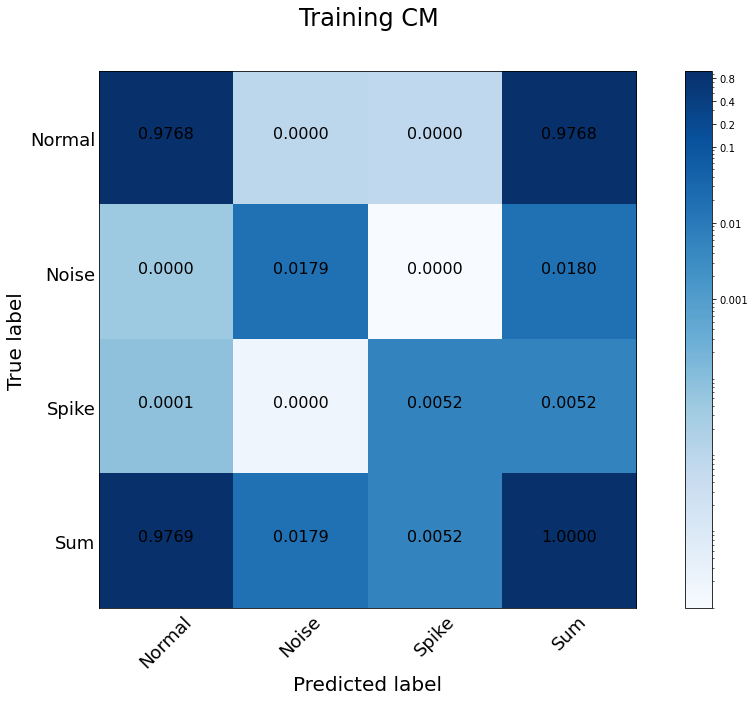

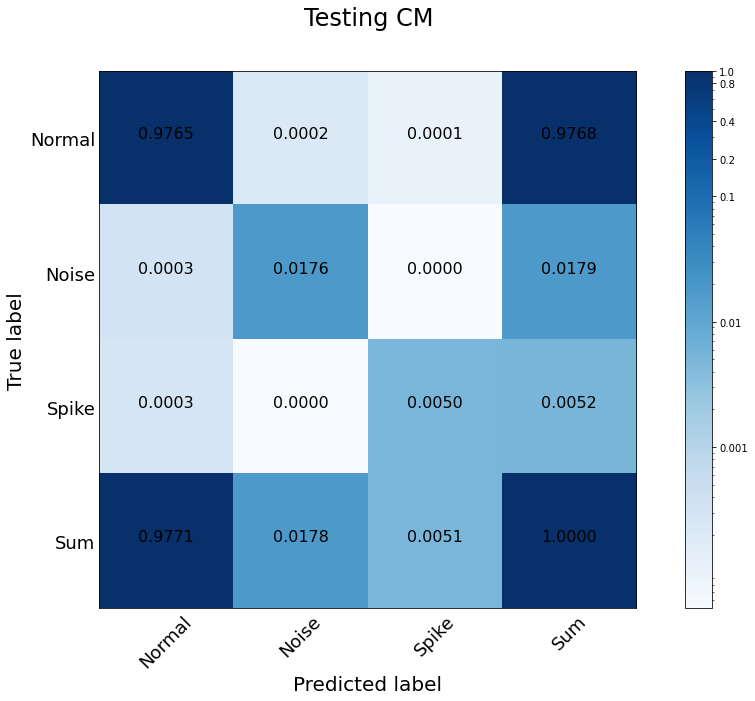

In [54]:
fig_kwargs = {"fontsize":16}

# Plot the confusion matrices.
fig, ax = plot_confusion_matrix(
    train_df,
    title="Training CM",
    **fig_kwargs
)
fig.savefig(plot_dir+"train_df.png", dpi=300)

fig, ax = plot_confusion_matrix(
    test_df,
    title="Testing CM",
    **fig_kwargs
)
fig.savefig(plot_dir+"test_df.png", dpi=300)

In [34]:
# # Plot the confusion matrices.
# fig, ax = plot_confusion_matrix(
#     train_df.divide(train_df["sum"], axis=0),
#     title="Train CM",
# )
# # fig.savefig(plot_dir+"train_df.pdf")

# fig, ax = plot_confusion_matrix(
#     test_df.divide(test_df["sum"], axis=0),
#     title="Test CM",
# )
# # fig.savefig(plot_dir+"test_df.pdf")

In [27]:
test_df.values

array([[9.76507310e-01, 2.02248622e-04, 1.03513074e-04, 9.76813071e-01],
       [3.24871803e-04, 1.76227028e-02, 0.00000000e+00, 1.79475746e-02],
       [2.75504029e-04, 0.00000000e+00, 4.96385005e-03, 5.23935408e-03],
       [9.77107685e-01, 1.78249514e-02, 5.06736312e-03, 1.00000000e+00]])

In [ ]:
col_idx_names = ["", "spike", "noise", "sum"]

RF_cf = np.array(
    [[9.76582046e-01, 1.86324424e-04, 3.98129112e-05, 0], 
     [4.92087582e-04, 1.74587578e-02, 0.00000000e+00, 0], 
     [3.39206003e-04, 1.59251645e-06, 4.90017311e-03, 0], 
    ]
)

RF_cf_df = pd.DataFrame(
    data=RF_cf, 
    columns=col_idx_names, 
    index=["", "spike", "noise",]
)

RF_cf_df.loc[:, "sum"] = RF_cf_df.sum(axis=0)
# RF_cf_df.loc["sum", :] = RF_cf.sum(axis=1)

In [ ]:
# Plot the confusion matrices.
fig, ax = plot_confusion_matrix(
    RF_cf_df.divide(RF_cf_df["sum"], axis=0),
    title="RF test CM",
)
fig.savefig(plot_dir+"RF_test_df_"+modding_dirs[:-1]+".pdf")

## Random calculation checks

In [57]:
test_df.values

array([[9.76507310e-01, 2.02248622e-04, 1.03513074e-04, 9.76813071e-01],
       [3.24871803e-04, 1.76227028e-02, 0.00000000e+00, 1.79475746e-02],
       [2.75504029e-04, 0.00000000e+00, 4.96385005e-03, 5.23935408e-03],
       [9.77107685e-01, 1.78249514e-02, 5.06736312e-03, 1.00000000e+00]])

In [58]:
9.76507310e-01 / 9.76813071e-01

0.9996869810518741

In [59]:
1.76227028e-02 / 1.79475746e-02

0.9818988466553025

In [60]:
1.76227028e-02 / 1.78249514e-02

0.9886536240429806